In [ ]:
# In this analysis, we calculate the covariance matrix of a set of returns. 
# In one set, we compute the returns as is, and in the other we remove noise in the 
# returns by using a signal estimate in the form of MAF factors as our price estiamtes.
# We find that the sparsity of the MAF estiamted returns is slightly higher,
# but there are less values close to the value zero. This may mean that there are more
# significant values in the MAF estimated values.

In [87]:
from pymaf import maf
from concord import concord, robust_selection
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
def plot_cov(omega):
    sparsity = len(omega.nonzero()[0]) / (n_stocks*n_stocks - n_stocks)
    plt.imshow(omega.todense(), cmap='gray', interpolation='nearest')
    plt.title(f"{sparsity}")
    plt.show()
def normalize(matrix, axis=0):
    n, p = matrix.shape
    return (matrix - np.mean(matrix, axis=axis)) / np.std(matrix, axis=axis)
def p_transform(x, p):
    # Symmetrically raise values to the p^th power
    sign = (x > 0) * 2 - 1
    positive = sign * np.power(np.abs(x), p) * (np.abs(x) > 1)
    negative = sign * np.abs(x)*p * (np.abs(x) < 1)
    return positive + negative

def get_omega(prices):
    returns = np.diff(prices, axis=0) / prices[:-1, :]
    n, p = returns.shape
    norm_returns = normalize(returns)
    opt_lambda = robust_selection(norm_returns)
    print(np.diag(np.cov(norm_returns.T)) / n * (n - 1))
    omega = concord(norm_returns, opt_lambda)
    return omega, opt_lambda

In [88]:
prices = pd.read_csv('../concord/src/flatData.csv')
prices = prices.pivot(columns="ticker", index="date", values="close")
prices = prices.iloc[-300:, :]
prices.head()

ticker,AA,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2011-09-19,11.39,47.80,62.24,6.95,82.38,16.01,94.74,44.41,31.97,15.63,...,30.88,26.26,17.21,61.23,26.71,48.45,73.17,34.10,51.15,71.45
2011-09-20,11.07,48.38,61.67,6.86,81.46,16.03,93.86,44.00,31.78,15.50,...,31.12,26.04,17.38,61.49,26.96,48.96,73.62,34.22,51.00,71.75
2011-09-21,10.67,47.36,59.21,6.34,77.28,15.36,90.48,42.71,30.76,14.86,...,30.50,25.09,17.00,60.47,26.44,46.79,72.52,33.68,50.05,69.77
2011-09-22,9.95,45.79,56.97,6.02,71.96,14.87,86.55,39.88,29.06,14.53,...,29.81,24.19,16.66,58.69,25.93,46.01,66.16,33.45,49.04,67.13
2011-09-23,9.91,45.61,57.74,6.27,71.92,15.14,86.39,38.74,29.34,14.69,...,29.73,24.19,16.63,58.77,26.02,45.75,66.75,33.72,49.54,67.20


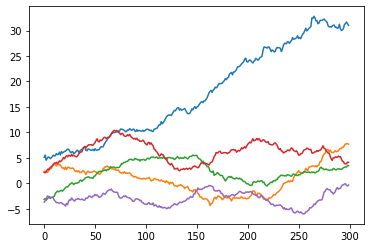

In [89]:
f, w = maf(prices.values)
n_mafs = 5
plt.plot(f[:, :n_mafs])
n_samples, n_stocks = f.shape


In [93]:
f_hat = np.hstack((np.ones(n_samples)[:, np.newaxis], f[:, :n_mafs]))
coefs, residuals, rank, s = np.linalg.lstsq(f_hat, prices.values, rcond=-1)
prices_hat = np.dot(f_hat, coefs)

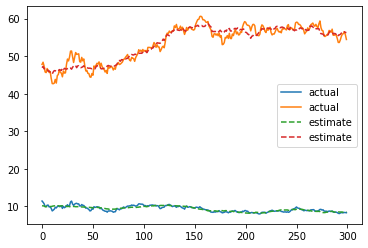

In [94]:
# Plot
plt.plot(prices.values[:, :2], label="actual")
plt.plot(prices_hat[:, :2], "--", label="estimate")
plt.legend()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
0.24818205837803406


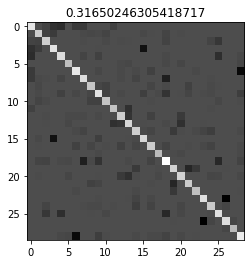

0.16169240774409263


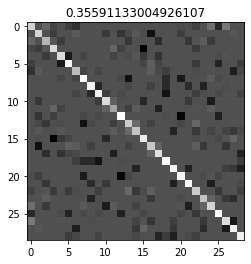

In [99]:
res_prices_i = prices.values[-225:, :] - prices_hat[-225:, :]
prices_i = prices.values[-225:, :]
prices_hat_i = prices_hat[-225:, :]
res_omega, res_opt_lambda = get_omega(res_prices_i)
omega_hat, opt_lambda_hat = get_omega(prices_hat_i)
omega, opt_lambda = get_omega(prices_i)
print(opt_lambda)
plot_cov(omega)
print(opt_lambda_hat)
plot_cov(omega_hat)

In [252]:
y = returns.ravel()
lam = 1 / np.mean(y)
fy = lam*np.exp(y*lam)

In [82]:
eps = 0.000001
sij = np.array(omega.todense()).ravel()
sij = sij[np.abs(sij) > eps]
print(len(sij))
sij_hat = np.array(omega_hat.todense()).ravel()
sij_hat = sij_hat[np.abs(sij_hat) > eps ]
print(len(sij_hat))

257
289


In [85]:
n_stocks*(n_stocks-1) / 2

406.0

(array([ 4.,  4.,  4., 18., 18., 10., 36., 42., 52., 30., 18., 16.,  6.,
         0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,  5.,  4.,
         1.,  1.,  6.,  6.]),
 array([-2.10989214, -1.88295739, -1.65602264, -1.4290879 , -1.20215315,
        -0.9752184 , -0.74828365, -0.5213489 , -0.29441416, -0.06747941,
         0.15945534,  0.38639009,  0.61332484,  0.84025958,  1.06719433,
         1.29412908,  1.52106383,  1.74799858,  1.97493332,  2.20186807,
         2.42880282,  2.65573757,  2.88267231,  3.10960706,  3.33654181,
         3.56347656,  3.79041131,  4.01734605,  4.2442808 ,  4.47121555,
         4.6981503 ]),
 <BarContainer object of 30 artists>)

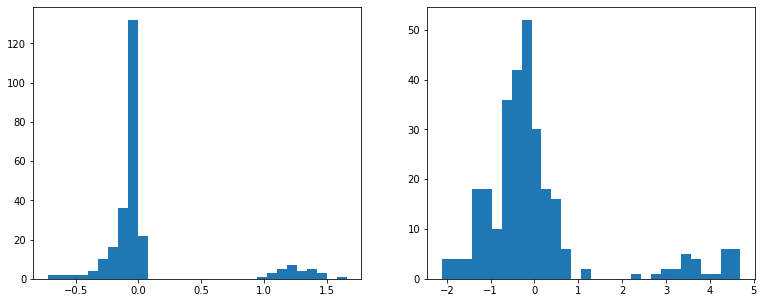

In [100]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(sij, bins=30)
plt.subplot(1,3,2)
plt.hist(sij_hat, bins=30)